##### **I. Install required libraries**

In [1]:
# Install the following libraries:
# - PyTorch
# - TorchVision (PyTorch)
# - scikit-learn
# - Matplotlib
# - Seaborn
# - Azure Machine Learning (ML) SDK
# - Torch-summary (PyTorch)
# - PyTorchViz (PyTorch)
!pip install torch torchvision scikit-learn matplotlib seaborn azureml-sdk torchsummary torchviz

##### **II. Import required libraries**

In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import MobileNetV2, ShuffleNetV2, SqueezeNet
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from torchviz import make_dot
from azureml.core import Workspace, Dataset

##### **III. Data Visualization**

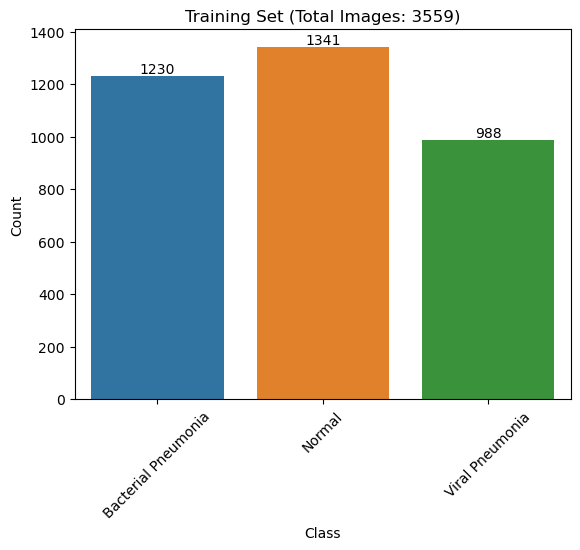

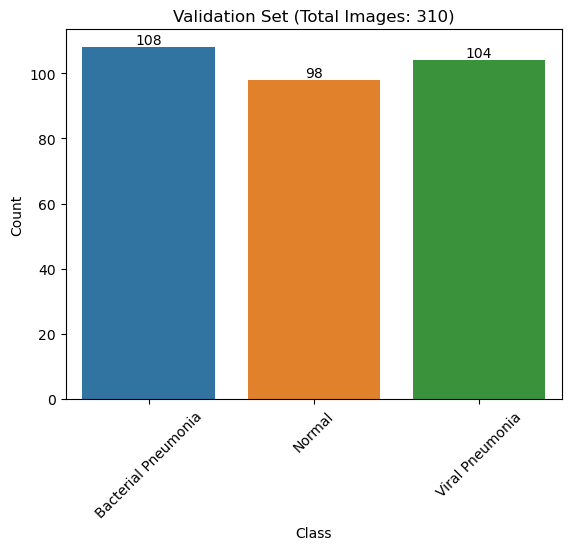

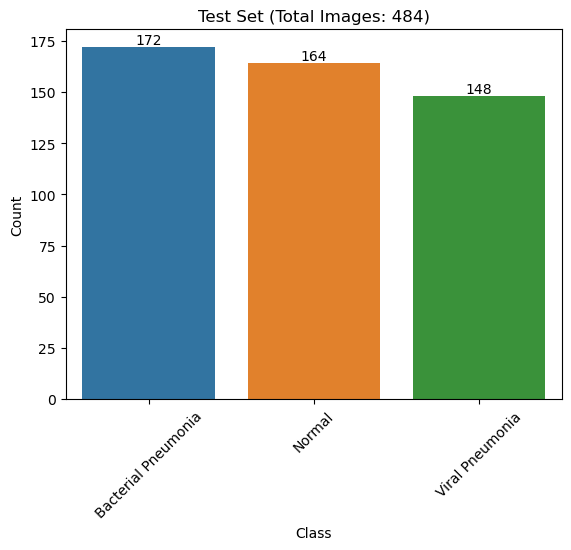

In [3]:
# Define dataset directory (Note: Replace the path "dataset/chest_xray", to where the dataset is saved)
data_dir = "dataset/chest_xray"

# Load the dataset's training, validation, & test set
image_datasets = {x: datasets.ImageFolder(root=os.path.join(data_dir, x))
                  for x in ['train', 'val', 'test']}

# Count occurrences of each class in each set
class_counts = {x: {cls: 0 for cls in image_datasets['train'].classes} for x in ['train', 'val', 'test']}
total_counts = {x: 0 for x in ['train', 'val', 'test']}

for phase in ['train', 'val', 'test']:
    for _, label in image_datasets[phase]:
        class_counts[phase][image_datasets[phase].classes[label]] += 1
        total_counts[phase] += 1

# Visualize class distribution via countplot
for phase in ['train', 'val', 'test']:
    plt.figure()
    ax = sns.barplot(x=list(class_counts[phase].keys()), y=list(class_counts[phase].values()))
    
    # Set label based on the phase and add total count
    if phase == 'train':
        plt.title(f'Training Set (Total Images: {total_counts[phase]})')
    elif phase == 'val':
        plt.title(f'Validation Set (Total Images: {total_counts[phase]})')
    else:
        plt.title(f'Test Set (Total Images: {total_counts[phase]})')
    
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Add count numbers on top of each bar
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')
    
    plt.show()


##### **IV. Data Preprocessing & Augmentation**

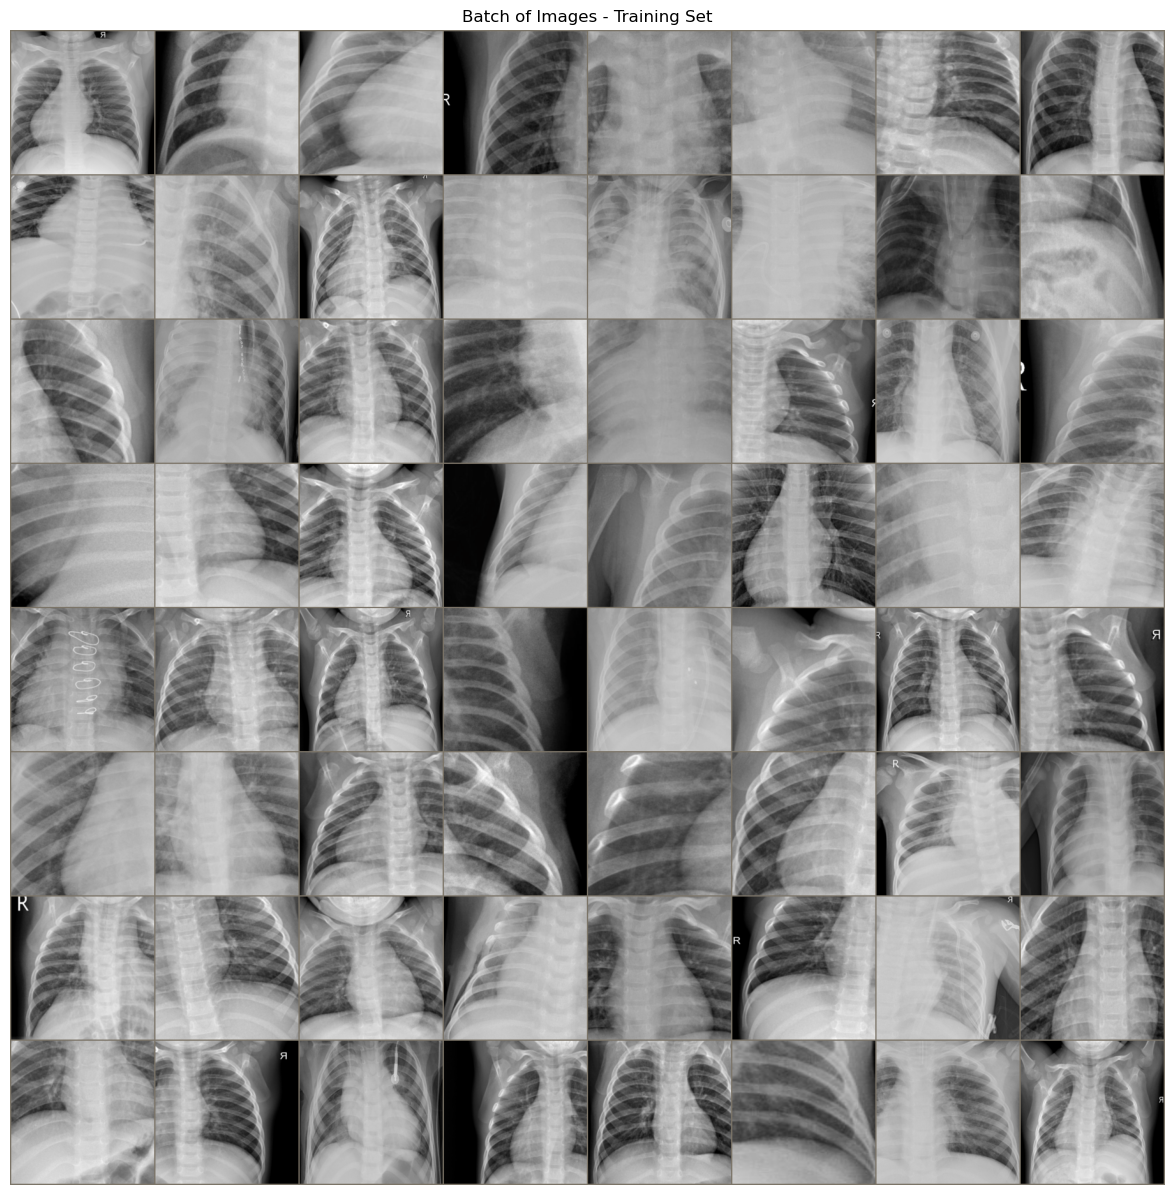

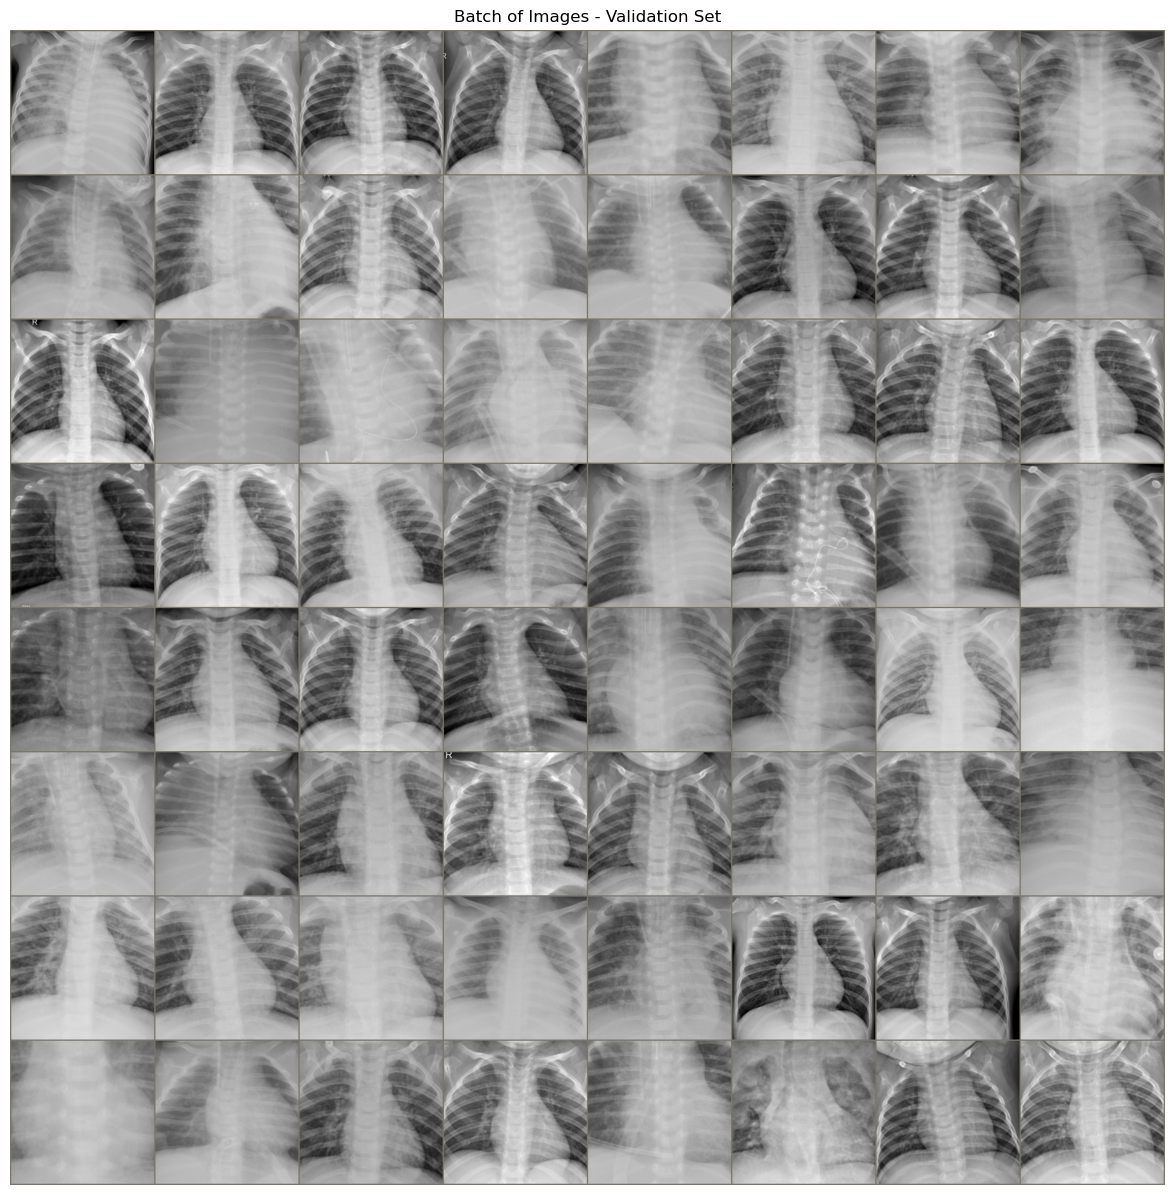

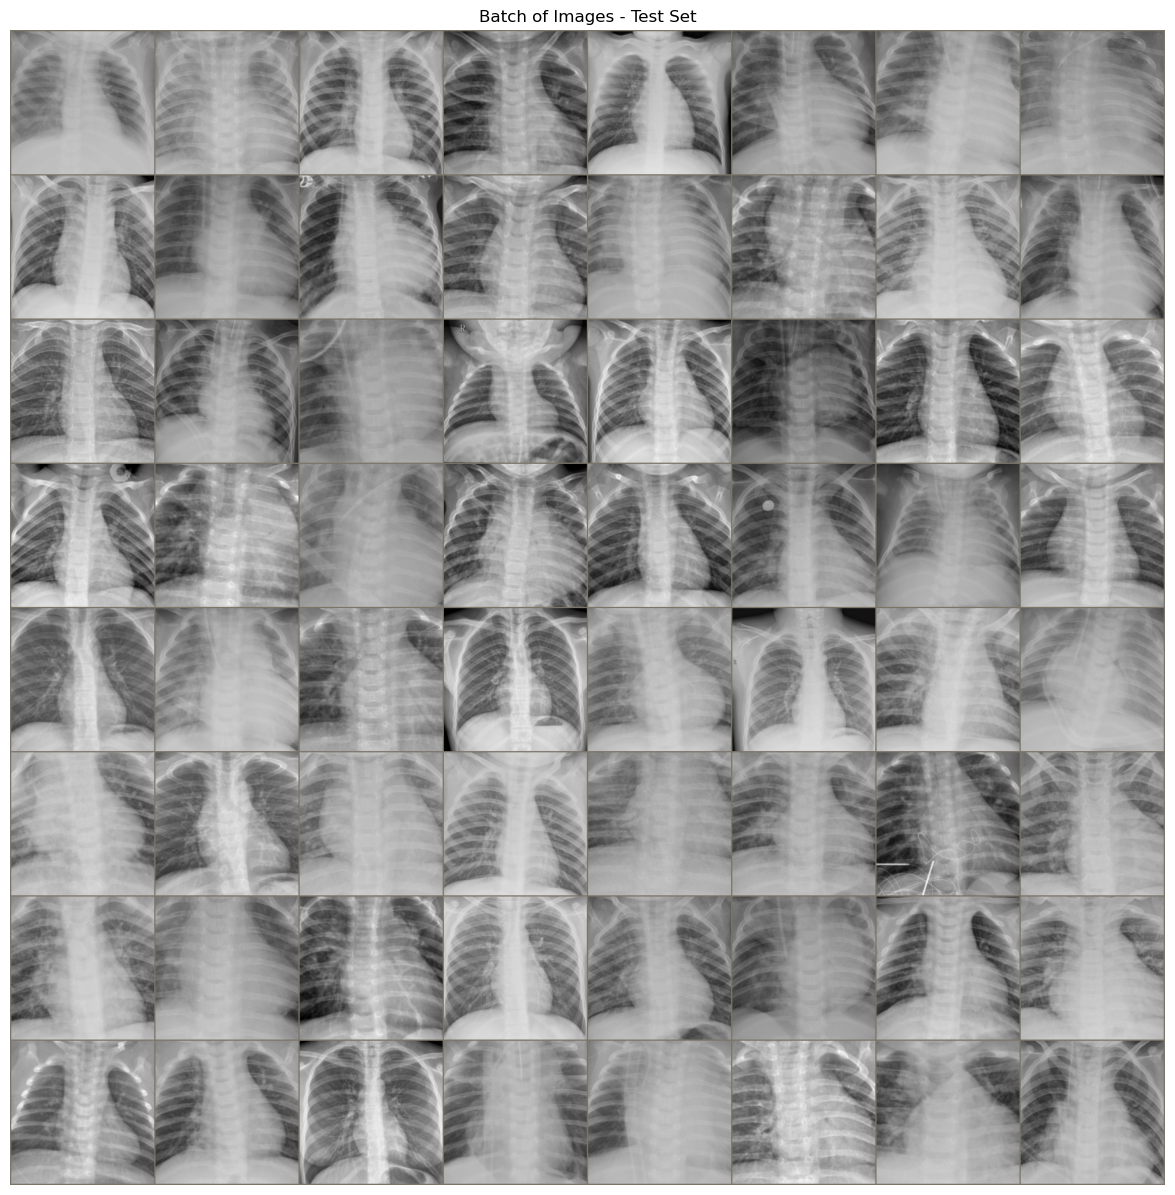

In [4]:
# Define data transforms for training, validation, and test sets
data_transforms = {
    'train': transforms.Compose([  # For the training set
        transforms.RandomResizedCrop(224),  # Randomly crop the image to 224x224 size
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
    ]),
    'val': transforms.Compose([  # For the validation set
        transforms.Resize(256),  # Resize the image to 256x256
        transforms.CenterCrop(224),  # Crop the center of the image to 224x224 size
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
    ]),
    'test': transforms.Compose([  # For the test set
        transforms.Resize(256),  # Resize the image to 256x256
        transforms.CenterCrop(224),  # Crop the center of the image to 224x224 size
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
    ])
}

# Apply transformations to the datasets
transformed_datasets = {x: datasets.ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x])
                        for x in ['train', 'val', 'test']}

# Create dataloaders for training, validation, & test sets
dataloaders = {x: torch.utils.data.DataLoader(transformed_datasets[x], batch_size=64, shuffle=True)
               for x in ['train', 'val', 'test']}

# Display a batch of images with dataset label
def show_batch_images(dataloader, dataset_label):
    images, labels = next(iter(dataloader))
    grid = torchvision.utils.make_grid(images, nrow=8)
    
    # Denormalize the images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    grid = grid * std + mean
    
    plt.figure(figsize=(15, 15))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f'Batch of Images - {dataset_label}')
    plt.axis('off')
    plt.show()

# Show a batch of training images
show_batch_images(dataloaders['train'], 'Training Set')

# Show a batch of validation images
show_batch_images(dataloaders['val'], 'Validation Set')

# Show a batch of test images
show_batch_images(dataloaders['test'], 'Test Set')

##### **V. Build the architectures for each model**

In [6]:
# Define no. of classes in the train set
num_classes = len(image_datasets['train'].classes)

##### **Model 1: MobileNet-V2**

In [7]:
# Load MobileNet-V2 model with pre-trained weights
mobilenet_model = torchvision.models.mobilenet_v2(pretrained=True)

# Retrieve the no. of input features for the final fully connected layer
num_ftrs = mobilenet_model.classifier[1].in_features

# Replace the final fully connected layer with a new one that matches the no. of classes in the dataset
mobilenet_model.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Display the updated model to verify the modifications
print(mobilenet_model)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

##### **Model 2: ShuffleNet-V2**

In [8]:
# Load ShuffleNet-V2 model with pre-trained weights
shufflenet_model = torchvision.models.shufflenet_v2_x1_0(pretrained=True)

# Retrieve the no. of input features for the final fully connected layer
num_ftrs = shufflenet_model.fc.in_features

# Replace the final fully connected layer with a new one that matches the no. of classes in the dataset
shufflenet_model.fc = nn.Linear(num_ftrs, num_classes)

# Display the updated model to verify the modifications
print(shufflenet_model)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

##### **Model 3: SqueezeNet 1.1**

In [9]:
# Load SqueezeNet 1.1 model with pre-trained weights
squeezenet_model = torchvision.models.squeezenet1_1(pretrained=True)

# Replace the final fully connected layer with a 1x1 convolutional layer to adapt the model for a new no. of classes
squeezenet_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))

# Update the no. of classes in the model configuration
squeezenet_model.num_classes = num_classes

# Display the updated model to verify the modifications
print(squeezenet_model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

##### **VI. Model Training & Evaluation**

##### **Model 1: MobileNet-V2**

###### **_Training_**

In [20]:
# Define loss function (for classification task)
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(mobilenet_model.parameters(), lr=0.001)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1, verbose=True)

# Define no. of epochs
num_epochs = 25

# Define device for training (Azure ML compute targets typically use CPU)
device = torch.device("cpu")

# Move the model to the appropriate device
mobilenet_model = mobilenet_model.to(device)

# Initialize lists to store training & validation losses & accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize variables to track the best validation loss
best_val_loss = float('inf')
best_model_state = None

# Initialize variables for early stopping
patience = 10  # No. of epochs to wait if validation loss stops improving
counter = 0  # Counter to track the no. of epochs since the last improvement

# Loop over the dataset for the specified no. of epochs
for epoch in range(num_epochs):
    # Set the model to train mode
    mobilenet_model.train()
    
    # Initialize variables to track loss & accuracy
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Iterate over the training dataset in batches
    for inputs, labels in dataloaders['train']:
        # Move inputs & labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = mobilenet_model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass & optimization
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item() * inputs.size(0)
        
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    
    # Compute training loss & accuracy for the epoch
    epoch_train_loss = running_loss / len(dataloaders['train'].dataset)
    epoch_train_accuracy = correct_predictions / total_predictions
    
    # Append training loss & accuracy to lists
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    
    # Initialize variables to track loss & accuracy for validation
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    
    # Evaluate the model on the validation dataset
    mobilenet_model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = mobilenet_model(inputs)
            val_loss = criterion(outputs, labels)
            
            # Update running validation loss
            val_running_loss += val_loss.item() * inputs.size(0)
            
            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            val_total_predictions += labels.size(0)
            val_correct_predictions += (predicted == labels).sum().item()
    
    # Compute validation loss & accuracy for the epoch
    epoch_val_loss = val_running_loss / len(dataloaders['val'].dataset)
    epoch_val_accuracy = val_correct_predictions / val_total_predictions
    
    # Append validation loss & accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    
    # Print statistics for every epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')
    
    # Update learning rate
    scheduler.step(epoch_val_loss)
    
    # Check if current validation loss is the best
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = mobilenet_model.state_dict()
        counter = 0  # Reset the counter if there's an improvement
    else:
        counter += 1  # Increment the counter if there's no improvement
    
    # Check if early stopping criteria are met
    if counter >= patience:
        print(f'Early stopping after {epoch + 1} epochs.')
        break

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'models/mobilenetv2_model.pth')

Epoch [1/25], Train Loss: 0.7125, Train Accuracy: 0.6932, Val Loss: 0.5544, Val Accuracy: 0.7645
Epoch [2/25], Train Loss: 0.5749, Train Accuracy: 0.7623, Val Loss: 0.4591, Val Accuracy: 0.8323
Epoch [3/25], Train Loss: 0.5339, Train Accuracy: 0.7733, Val Loss: 0.4446, Val Accuracy: 0.8065
Epoch [4/25], Train Loss: 0.5314, Train Accuracy: 0.7735, Val Loss: 0.4612, Val Accuracy: 0.8065
Epoch [5/25], Train Loss: 0.4993, Train Accuracy: 0.7901, Val Loss: 0.4848, Val Accuracy: 0.8065
Epoch [6/25], Train Loss: 0.4987, Train Accuracy: 0.7873, Val Loss: 0.4490, Val Accuracy: 0.8129
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch [7/25], Train Loss: 0.4564, Train Accuracy: 0.8019, Val Loss: 0.3977, Val Accuracy: 0.8548
Epoch [8/25], Train Loss: 0.4344, Train Accuracy: 0.8129, Val Loss: 0.3892, Val Accuracy: 0.8484
Epoch [9/25], Train Loss: 0.4192, Train Accuracy: 0.8199, Val Loss: 0.4062, Val Accuracy: 0.8484
Epoch [10/25], Train Loss: 0.4109, Train Accuracy: 0.8255, Val Lo

###### **_Evaluation_ (Training & Validation Sets)**

Training History:

     Epoch  train_loss  train_accuracy  val_loss  val_accuracy
0       1      0.7125          0.6932    0.5544        0.7645
1       2      0.5749          0.7623    0.4591        0.8323
2       3      0.5339          0.7733    0.4446        0.8065
3       4      0.5314          0.7735    0.4612        0.8065
4       5      0.4993          0.7901    0.4848        0.8065
5       6      0.4987          0.7873    0.4490        0.8129
6       7      0.4564          0.8019    0.3977        0.8548
7       8      0.4344          0.8129    0.3892        0.8484
8       9      0.4192          0.8199    0.4062        0.8484
9      10      0.4109          0.8255    0.4012        0.8484
10     11      0.4149          0.8264    0.3814        0.8452
11     12      0.4038          0.8286    0.3875        0.8387
12     13      0.3994          0.8328    0.3835        0.8613
13     14      0.3949          0.8325    0.3760        0.8613
14     15      0.3868          0.8398    0.3776   

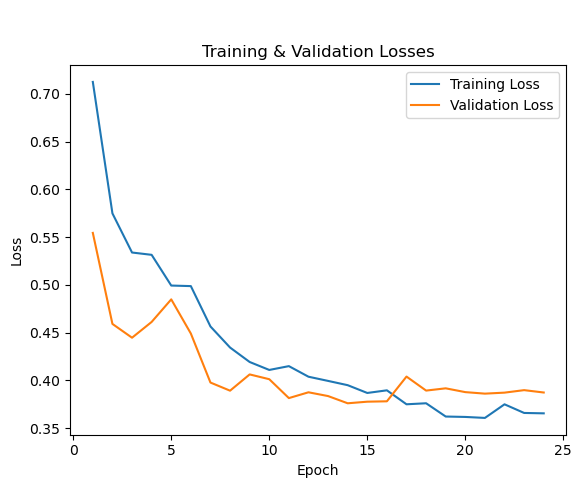

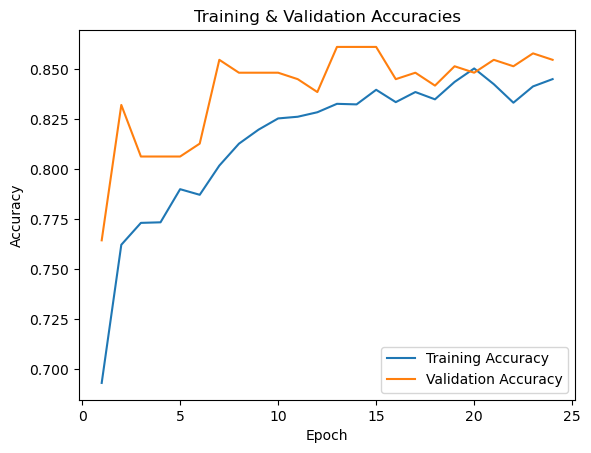


1. Overall Loss & Accuracy (Train & Validation Sets):

          Set    Loss         Accuracy
0       Train  0.3654  84.52% (0.8452)
1  Validation  0.3872  85.48% (0.8548)


In [52]:
# Ensure all lists have the same length
min_length = min(len(train_losses), len(train_accuracies), len(val_losses), len(val_accuracies))
train_losses = train_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_losses = val_losses[:min_length]
val_accuracies = val_accuracies[:min_length]

# Create a DataFrame for the model's training history with values rounded to four decimal places
mobilenet_history_df = pd.DataFrame({
    'Epoch': range(1, min_length + 1),
    'train_loss': [round(loss, 4) for loss in train_losses],
    'train_accuracy': [round(accuracy, 4) for accuracy in train_accuracies],
    'val_loss': [round(loss, 4) for loss in val_losses],
    'val_accuracy': [round(accuracy, 4) for accuracy in val_accuracies]
})

# Display the model's training history
print("Training History:\n\n", mobilenet_history_df)

# Plot training & validation losses
plt.plot(range(1, min_length + 1), train_losses, label='Training Loss')
plt.plot(range(1, min_length + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('\n\nTraining & Validation Losses')
plt.legend()
plt.show()

# Plot training & validation accuracies
plt.plot(range(1, min_length + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, min_length + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracies')
plt.legend()
plt.show()


# Convert accuracy to percentage
train_accuracy_percentage = train_accuracies[-1] * 100  # Using the last epoch's accuracy
val_accuracy_percentage = val_accuracies[-1] * 100  # Using the last epoch's accuracy

# Create a Pandas DataFrame to display the results with values rounded to four decimal places
evaluation_results = pd.DataFrame({
    'Set': ['Train', 'Validation'],
    'Loss': [f'{train_losses[-1]:.4f}', f'{val_losses[-1]:.4f}'],  # Using the last epoch's loss
    'Accuracy': [f'{train_accuracy_percentage:.2f}% ({train_accuracies[-1]:.4f})', 
                  f'{val_accuracy_percentage:.2f}% ({val_accuracies[-1]:.4f})']
})

# Display the evaluation results DataFrame (Training & Validation Sets)
print('\n1. Overall Loss & Accuracy (Train & Validation Sets):\n')
print(evaluation_results)

###### **_Evaluation_ (Test Set)**


2. Accuracy (Test Set): 90.08% (0.9008)


3. Confusion Matrix:



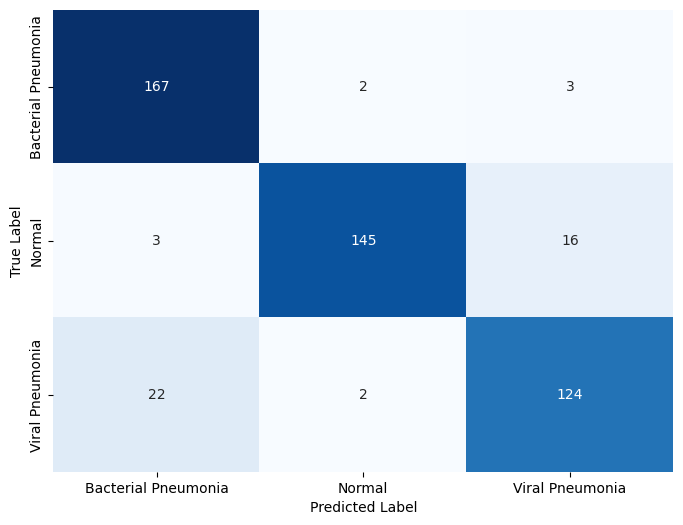



4. Classification Report:

                      precision    recall  f1-score   support

Bacterial Pneumonia       0.87      0.97      0.92       172
             Normal       0.97      0.88      0.93       164
    Viral Pneumonia       0.87      0.84      0.85       148

           accuracy                           0.90       484
          macro avg       0.90      0.90      0.90       484
       weighted avg       0.90      0.90      0.90       484


5. AUC-ROC Score: 0.9822600046131491 



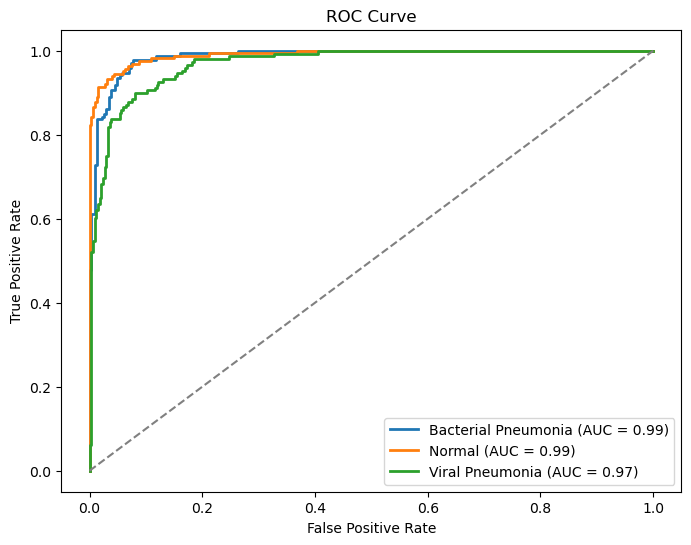

In [13]:
# Define device (Azure ML compute targets typically use CPU)
device = torch.device("cpu")

# Define class names
class_names = ['Bacterial Pneumonia', 'Normal', 'Viral Pneumonia']

# Load the modified MobileNet-V2 model
mobilenet_model = torchvision.models.mobilenet_v2(pretrained=False)
num_ftrs = mobilenet_model.classifier[1].in_features
mobilenet_model.classifier[1] = nn.Linear(num_ftrs, num_classes)
mobilenet_model.load_state_dict(torch.load('models/mobilenetv2_model.pth'))
mobilenet_model.eval()

# Define lists to store true labels & predicted probabilities
true_labels = []
predicted_probs = []

# Evaluate the model on the test set
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = mobilenet_model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Append true labels & predicted probabilities
        true_labels.extend(labels.cpu().numpy())
        predicted_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, np.argmax(predicted_probs, axis=1))
accuracy_decimal = round(accuracy, 4)
accuracy_percent = round(accuracy * 100, 2)
print("\n2. Accuracy (Test Set):", f"{accuracy_percent:.2f}% ({accuracy_decimal:.4f})\n")

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, np.argmax(predicted_probs, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
print("\n3. Confusion Matrix:\n")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Generate classification report
class_report = classification_report(true_labels, np.argmax(predicted_probs, axis=1), target_names=class_names)
print("\n\n4. Classification Report:\n\n", class_report)

# Compute AUC-ROC score
auc_roc = roc_auc_score(true_labels, predicted_probs, multi_class='ovr')
print("\n5. AUC-ROC Score:", auc_roc, '\n')

# Calculate fpr (False Positive Rate) & tpr (True Positive Rate) for plotting the ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve((np.array(true_labels) == i).astype(int), [probs[i] for probs in predicted_probs])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

##### **Model 2: ShuffleNet-V2**

###### **_Training_**

In [81]:
# Define loss function (for classification task)
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(shufflenet_model.parameters(), lr=0.001)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1, verbose=True)

# Define no. of epochs
num_epochs = 25

# Define device for training (Azure ML compute targets typically use CPU)
device = torch.device("cpu")

# Move the model to the appropriate device
shufflenet_model = shufflenet_model.to(device)

# Initialize lists to store training & validation losses & accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize variables to track the best validation loss
best_val_loss = float('inf')
best_model_state = None

# Initialize variables for early stopping
patience = 10  # No. of epochs to wait if validation loss stops improving
counter = 0  # Counter to track the no. of epochs since the last improvement

# Loop over the dataset for the specified no. of epochs
for epoch in range(num_epochs):
    # Set the model to train mode
    shufflenet_model.train()
    
    # Initialize variables to track loss & accuracy
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Iterate over the training dataset in batches
    for inputs, labels in dataloaders['train']:
        # Move inputs & labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = shufflenet_model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass & optimization
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item() * inputs.size(0)
        
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    
    # Compute training loss & accuracy for the epoch
    epoch_train_loss = running_loss / len(dataloaders['train'].dataset)
    epoch_train_accuracy = correct_predictions / total_predictions
    
    # Append training loss & accuracy to lists
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    
    # Initialize variables to track loss & accuracy for validation
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    
    # Evaluate the model on the validation dataset
    shufflenet_model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = shufflenet_model(inputs)
            val_loss = criterion(outputs, labels)
            
            # Update running validation loss
            val_running_loss += val_loss.item() * inputs.size(0)
            
            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            val_total_predictions += labels.size(0)
            val_correct_predictions += (predicted == labels).sum().item()
    
    # Compute validation loss & accuracy for the epoch
    epoch_val_loss = val_running_loss / len(dataloaders['val'].dataset)
    epoch_val_accuracy = val_correct_predictions / val_total_predictions
    
    # Append validation loss & accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    
    # Print statistics for every epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')
    
    # Update learning rate
    scheduler.step(epoch_val_loss)
    
    # Check if current validation loss is the best
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = shufflenet_model.state_dict()
        counter = 0  # Reset the counter if there's an improvement
    else:
        counter += 1  # Increment the counter if there's no improvement
    
    # Check if early stopping criteria are met
    if counter >= patience:
        print(f'Early stopping after {epoch + 1} epochs.')
        break

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'models/shufflenetv2_model.pth')

Epoch [1/25], Train Loss: 0.4012, Train Accuracy: 0.8258, Val Loss: 0.4682, Val Accuracy: 0.7839
Epoch [2/25], Train Loss: 0.4022, Train Accuracy: 0.8353, Val Loss: 0.4072, Val Accuracy: 0.8129
Epoch [3/25], Train Loss: 0.3835, Train Accuracy: 0.8376, Val Loss: 0.3922, Val Accuracy: 0.8194
Epoch [4/25], Train Loss: 0.3903, Train Accuracy: 0.8365, Val Loss: 0.4293, Val Accuracy: 0.8355
Epoch [5/25], Train Loss: 0.3815, Train Accuracy: 0.8382, Val Loss: 0.4808, Val Accuracy: 0.8000
Epoch [6/25], Train Loss: 0.3741, Train Accuracy: 0.8379, Val Loss: 0.4240, Val Accuracy: 0.8452
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch [7/25], Train Loss: 0.3464, Train Accuracy: 0.8508, Val Loss: 0.3834, Val Accuracy: 0.8710
Epoch [8/25], Train Loss: 0.3351, Train Accuracy: 0.8640, Val Loss: 0.3702, Val Accuracy: 0.8645
Epoch [9/25], Train Loss: 0.3305, Train Accuracy: 0.8657, Val Loss: 0.3744, Val Accuracy: 0.8710
Epoch [10/25], Train Loss: 0.3172, Train Accuracy: 0.8722, Val Lo

###### **_Evaluation_ (Training & Validation Sets)**

Training History:

     Epoch  train_loss  train_accuracy  val_loss  val_accuracy
0       1      0.4012          0.8258    0.4682        0.7839
1       2      0.4022          0.8353    0.4072        0.8129
2       3      0.3835          0.8376    0.3922        0.8194
3       4      0.3903          0.8365    0.4293        0.8355
4       5      0.3815          0.8382    0.4808        0.8000
5       6      0.3741          0.8379    0.4240        0.8452
6       7      0.3464          0.8508    0.3834        0.8710
7       8      0.3351          0.8640    0.3702        0.8645
8       9      0.3305          0.8657    0.3744        0.8710
9      10      0.3172          0.8722    0.3649        0.8548
10     11      0.3118          0.8685    0.3653        0.8548
11     12      0.3160          0.8724    0.3725        0.8548
12     13      0.2974          0.8778    0.3887        0.8484
13     14      0.2970          0.8744    0.3956        0.8484
14     15      0.3074          0.8724    0.3914   

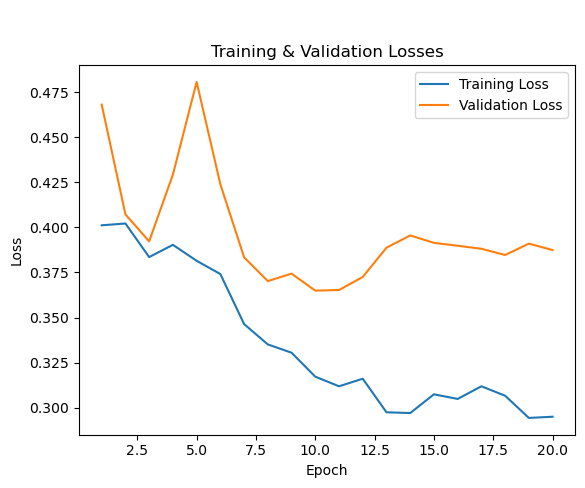

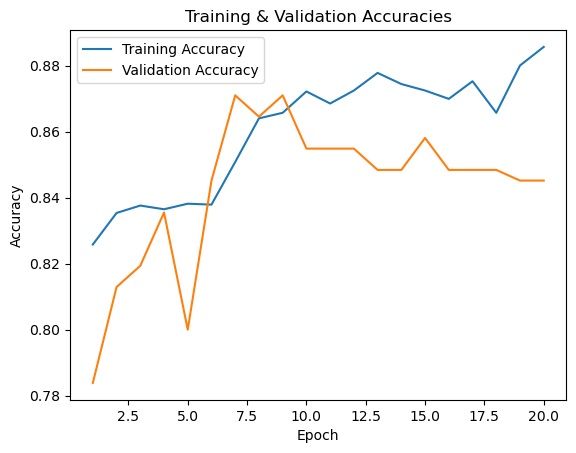


1. Overall Loss & Accuracy (Train & Validation Sets):

          Set    Loss         Accuracy
0       Train  0.2949  88.56% (0.8856)
1  Validation  0.3874  84.52% (0.8452)


In [86]:
# Ensure all lists have the same length
min_length = min(len(train_losses), len(train_accuracies), len(val_losses), len(val_accuracies))
train_losses = train_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_losses = val_losses[:min_length]
val_accuracies = val_accuracies[:min_length]

# Create DataFrame for the model's training history with values rounded to four decimal places
shufflenet_history_df = pd.DataFrame({
    'Epoch': range(1, min_length + 1),
    'train_loss': [round(loss, 4) for loss in train_losses],
    'train_accuracy': [round(accuracy, 4) for accuracy in train_accuracies],
    'val_loss': [round(loss, 4) for loss in val_losses],
    'val_accuracy': [round(accuracy, 4) for accuracy in val_accuracies]
})

# Display the model's training history
print("Training History:\n\n", shufflenet_history_df)

# Plot training & validation losses
plt.plot(range(1, min_length + 1), train_losses, label='Training Loss')
plt.plot(range(1, min_length + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('\n\nTraining & Validation Losses')
plt.legend()
plt.show()

# Plot training & validation accuracies
plt.plot(range(1, min_length + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, min_length + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracies')
plt.legend()
plt.show()


# Convert accuracy to percentage
train_accuracy_percentage = train_accuracies[-1] * 100  # Using the last epoch's accuracy
val_accuracy_percentage = val_accuracies[-1] * 100  # Using the last epoch's accuracy

# Create a Pandas DataFrame to display the results with values rounded to four decimal places
evaluation_results = pd.DataFrame({
    'Set': ['Train', 'Validation'],
    'Loss': [f'{train_losses[-1]:.4f}', f'{val_losses[-1]:.4f}'],  # Using the last epoch's loss
    'Accuracy': [f'{train_accuracy_percentage:.2f}% ({train_accuracies[-1]:.4f})', 
                  f'{val_accuracy_percentage:.2f}% ({val_accuracies[-1]:.4f})']
})

# Display the evaluation results DataFrame (Training & Validation Sets)
print('\n1. Overall Loss & Accuracy (Train & Validation Sets):\n')
print(evaluation_results)

###### **_Evaluation_ (Test Set)**


2. Accuracy (Test Set): 88.43% (0.8843)


3. Confusion Matrix:



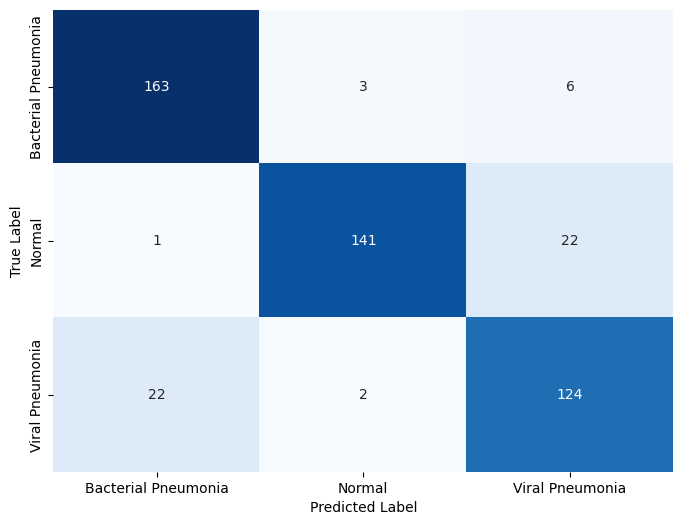



4. Classification Report:

                      precision    recall  f1-score   support

Bacterial Pneumonia       0.88      0.95      0.91       172
             Normal       0.97      0.86      0.91       164
    Viral Pneumonia       0.82      0.84      0.83       148

           accuracy                           0.88       484
          macro avg       0.89      0.88      0.88       484
       weighted avg       0.89      0.88      0.88       484


5. AUC-ROC Score: 0.9776283231663796 



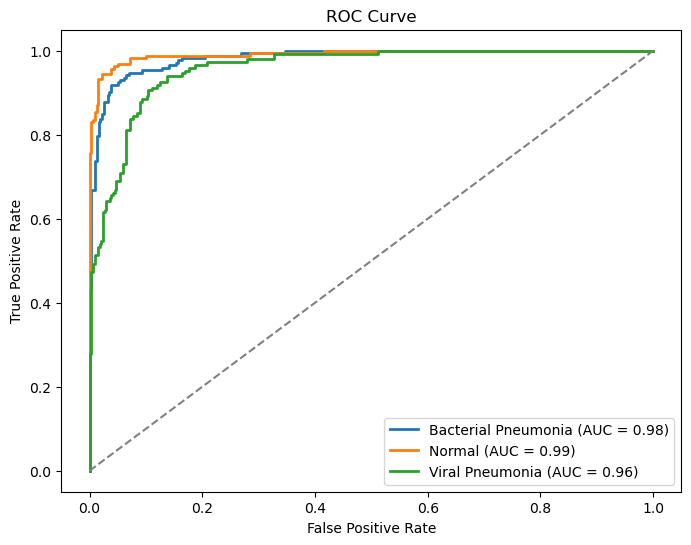

In [14]:
# Define device (Azure ML compute targets typically use CPU)
device = torch.device("cpu")

# Define class names
class_names = ['Bacterial Pneumonia', 'Normal', 'Viral Pneumonia']

# Load the modified ShuffleNet-V2 model
shufflenet_model = torchvision.models.shufflenet_v2_x1_0(pretrained=False)
num_ftrs = shufflenet_model.fc.in_features
shufflenet_model.fc = nn.Linear(num_ftrs, num_classes)
shufflenet_model.load_state_dict(torch.load('models/shufflenetv2_model.pth'))
shufflenet_model.eval()

# Define lists to store true labels & predicted probabilities
true_labels = []
predicted_probs = []

# Evaluate the model on the test set
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = shufflenet_model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Append true labels & predicted probabilities
        true_labels.extend(labels.cpu().numpy())
        predicted_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, np.argmax(predicted_probs, axis=1))
accuracy_decimal = round(accuracy, 4)
accuracy_percent = round(accuracy * 100, 2)
print("\n2. Accuracy (Test Set):", f"{accuracy_percent:.2f}% ({accuracy_decimal:.4f})\n")

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, np.argmax(predicted_probs, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
print("\n3. Confusion Matrix:\n")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Generate classification report
class_report = classification_report(true_labels, np.argmax(predicted_probs, axis=1), target_names=class_names)
print("\n\n4. Classification Report:\n\n", class_report)

# Compute AUC-ROC score
auc_roc = roc_auc_score(true_labels, predicted_probs, multi_class='ovr')
print("\n5. AUC-ROC Score:", auc_roc, '\n')

# Calculate fpr (False Positive Rate) & tpr (True Positive Rate) for plotting the ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve((np.array(true_labels) == i).astype(int), [probs[i] for probs in predicted_probs])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

##### **Model 3: SqueezeNet 1.1**


###### **_Training_**

In [38]:
# Define loss function (for classification task)
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(squeezenet_model.parameters(), lr=0.001)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1, verbose=True)

# Define no. of epochs
num_epochs = 25

# Define device for training (Azure ML compute targets typically use CPU)
device = torch.device("cpu")

# Move the model to the appropriate device
squeezenet_model = squeezenet_model.to(device)

# Initialize lists to store training & validation losses & accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize variables to track the best validation loss
best_val_loss = float('inf')
best_model_state = None

# Initialize variables for early stopping
patience = 10  # No. of epochs to wait if validation loss stops improving
counter = 0  # Counter to track the no. of epochs since the last improvement

# Loop over the dataset for the specified no. of epochs
for epoch in range(num_epochs):
    # Set the model to train mode
    squeezenet_model.train()
    
    # Initialize variables to track loss & accuracy
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Iterate over the training dataset in batches
    for inputs, labels in dataloaders['train']:
        # Move inputs & labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = squeezenet_model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass & optimization
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item() * inputs.size(0)
        
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    
    # Compute training loss & accuracy for the epoch
    epoch_train_loss = running_loss / len(dataloaders['train'].dataset)
    epoch_train_accuracy = correct_predictions / total_predictions
    
    # Append training loss & accuracy to lists
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    
    # Initialize variables to track loss & accuracy for validation
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    
    # Evaluate the model on the validation dataset
    squeezenet_model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = squeezenet_model(inputs)
            val_loss = criterion(outputs, labels)
            
            # Update running validation loss
            val_running_loss += val_loss.item() * inputs.size(0)
            
            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            val_total_predictions += labels.size(0)
            val_correct_predictions += (predicted == labels).sum().item()
    
    # Compute validation loss & accuracy for the epoch
    epoch_val_loss = val_running_loss / len(dataloaders['val'].dataset)
    epoch_val_accuracy = val_correct_predictions / val_total_predictions
    
    # Append validation loss & accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    
    # Print statistics for every epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')
    
    # Update learning rate
    scheduler.step(epoch_val_loss)
    
    # Check if current validation loss is the best
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = squeezenet_model.state_dict()
        counter = 0  # Reset the counter if there's an improvement
    else:
        counter += 1  # Increment the counter if there's no improvement
    
    # Check if early stopping criteria are met
    if counter >= patience:
        print(f'Early stopping after {epoch + 1} epochs.')
        break

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'models/squeezenet1_1_model.pth')

Epoch [1/25], Train Loss: 1.0257, Train Accuracy: 0.4906, Val Loss: 1.0543, Val Accuracy: 0.4774
Epoch [2/25], Train Loss: 0.8955, Train Accuracy: 0.6021, Val Loss: 0.9178, Val Accuracy: 0.5742
Epoch [3/25], Train Loss: 0.8513, Train Accuracy: 0.6038, Val Loss: 0.9151, Val Accuracy: 0.5968
Epoch [4/25], Train Loss: 0.7979, Train Accuracy: 0.6316, Val Loss: 0.7767, Val Accuracy: 0.7000
Epoch [5/25], Train Loss: 0.7848, Train Accuracy: 0.6302, Val Loss: 0.9253, Val Accuracy: 0.5097
Epoch [6/25], Train Loss: 0.7324, Train Accuracy: 0.6760, Val Loss: 0.7773, Val Accuracy: 0.7000
Epoch [7/25], Train Loss: 0.7075, Train Accuracy: 0.6965, Val Loss: 0.8801, Val Accuracy: 0.6290
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch [8/25], Train Loss: 0.6755, Train Accuracy: 0.7221, Val Loss: 0.8744, Val Accuracy: 0.6419
Epoch [9/25], Train Loss: 0.6420, Train Accuracy: 0.7291, Val Loss: 0.8797, Val Accuracy: 0.5968
Epoch [10/25], Train Loss: 0.6258, Train Accuracy: 0.7390, Val Lo

###### **_Evaluation_ (Training & Validation Sets)**

Training History:

     Epoch  train_loss  train_accuracy  val_loss  val_accuracy
0       1      1.0257          0.4906    1.0543        0.4774
1       2      0.8955          0.6021    0.9178        0.5742
2       3      0.8513          0.6038    0.9151        0.5968
3       4      0.7979          0.6316    0.7767        0.7000
4       5      0.7848          0.6302    0.9253        0.5097
5       6      0.7324          0.6760    0.7773        0.7000
6       7      0.7075          0.6965    0.8801        0.6290
7       8      0.6755          0.7221    0.8744        0.6419
8       9      0.6420          0.7291    0.8797        0.5968
9      10      0.6258          0.7390    0.8777        0.5645
10     11      0.6187          0.7457    0.8762        0.6000
11     12      0.6185          0.7353    0.8763        0.5968
12     13      0.6281          0.7401    0.8742        0.6097
13     14      0.6227          0.7378    0.8746        0.6000


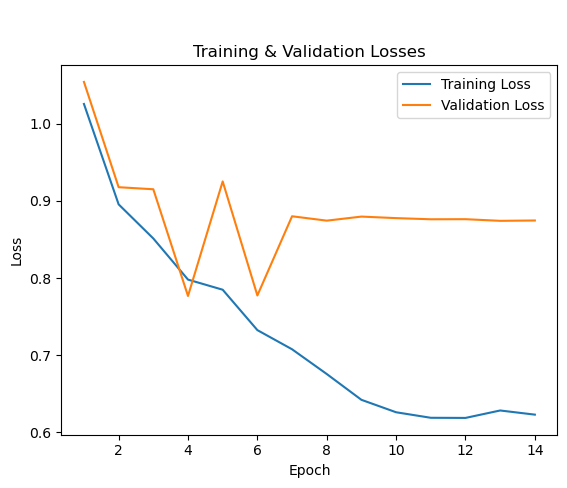

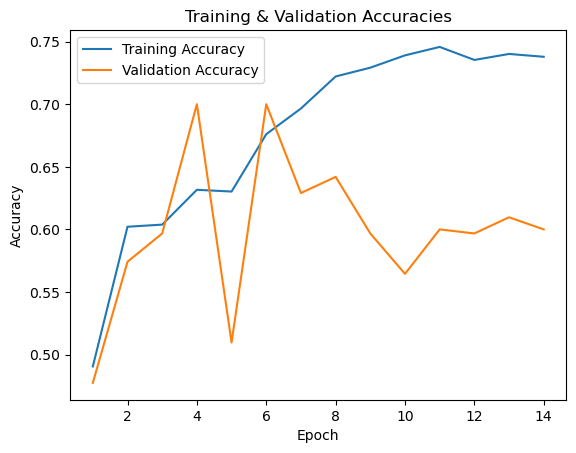


1. Overall Loss & Accuracy (Train & Validation Sets):

          Set    Loss         Accuracy
0       Train  0.6227  73.78% (0.7378)
1  Validation  0.8746  60.00% (0.6000)


In [39]:
# Ensure all lists have the same length
min_length = min(len(train_losses), len(train_accuracies), len(val_losses), len(val_accuracies))
train_losses = train_losses[:min_length]
train_accuracies = train_accuracies[:min_length]
val_losses = val_losses[:min_length]
val_accuracies = val_accuracies[:min_length]

# Create DataFrame for the model's training history with values rounded to four decimal places
squeezenet_history_df = pd.DataFrame({
    'Epoch': range(1, min_length + 1),
    'train_loss': [round(loss, 4) for loss in train_losses],
    'train_accuracy': [round(accuracy, 4) for accuracy in train_accuracies],
    'val_loss': [round(loss, 4) for loss in val_losses],
    'val_accuracy': [round(accuracy, 4) for accuracy in val_accuracies]
})

# Display the model's training history
print("Training History:\n\n", squeezenet_history_df)

# Plot training & validation losses
plt.plot(range(1, min_length + 1), train_losses, label='Training Loss')
plt.plot(range(1, min_length + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('\n\nTraining & Validation Losses')
plt.legend()
plt.show()

# Plot training & validation accuracies
plt.plot(range(1, min_length + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, min_length + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracies')
plt.legend()
plt.show()


# Convert accuracy to percentage
train_accuracy_percentage = train_accuracies[-1] * 100  # Using the last epoch's accuracy
val_accuracy_percentage = val_accuracies[-1] * 100  # Using the last epoch's accuracy

# Create a Pandas DataFrame to display the results with values rounded to four decimal places
evaluation_results = pd.DataFrame({
    'Set': ['Train', 'Validation'],
    'Loss': [f'{train_losses[-1]:.4f}', f'{val_losses[-1]:.4f}'],  # Using the last epoch's loss
    'Accuracy': [f'{train_accuracy_percentage:.2f}% ({train_accuracies[-1]:.4f})', 
                  f'{val_accuracy_percentage:.2f}% ({val_accuracies[-1]:.4f})']
})

# Display the evaluation results DataFrame (Training & Validation Sets)
print('\n1. Overall Loss & Accuracy (Train & Validation Sets):\n')
print(evaluation_results)

###### **_Evaluation_ (Test Set)**


2. Accuracy (Test Set): 56.61% (0.5661)


3. Confusion Matrix:



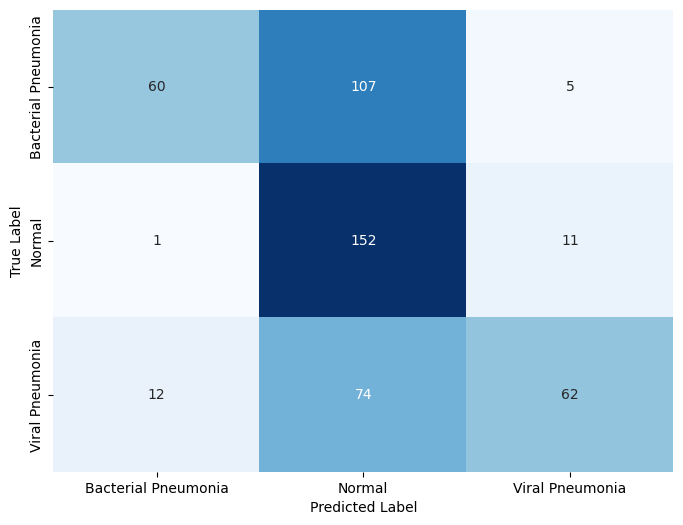



4. Classification Report:

                      precision    recall  f1-score   support

Bacterial Pneumonia       0.82      0.35      0.49       172
             Normal       0.46      0.93      0.61       164
    Viral Pneumonia       0.79      0.42      0.55       148

           accuracy                           0.57       484
          macro avg       0.69      0.56      0.55       484
       weighted avg       0.69      0.57      0.55       484


5. AUC-ROC Score: 0.8102891074215699 



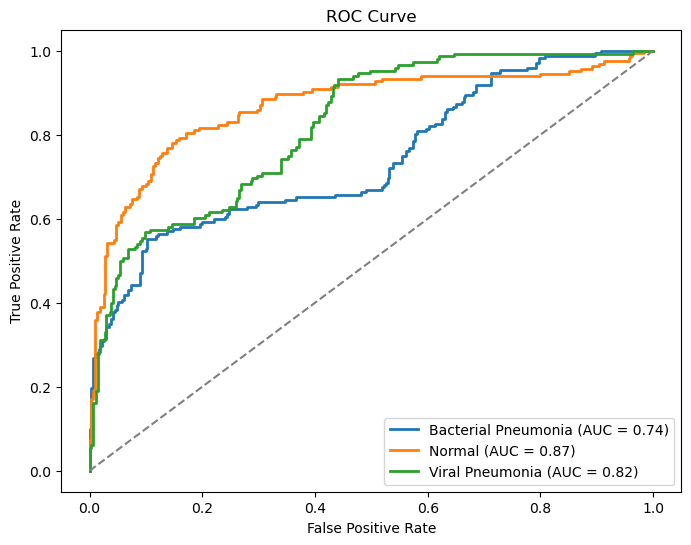

In [15]:
# Define device (Azure ML compute targets typically use CPU)
device = torch.device("cpu")

# Define class names
class_names = ['Bacterial Pneumonia', 'Normal', 'Viral Pneumonia']

# Load the modified SqueezeNet 1.1 model
squeezenet_model = torchvision.models.squeezenet1_1(pretrained=False)
num_ftrs = squeezenet_model.classifier[1].in_channels
squeezenet_model.classifier[1] = nn.Conv2d(num_ftrs, num_classes, kernel_size=(1, 1))
squeezenet_model.load_state_dict(torch.load('models/squeezenet1_1_model.pth'))
squeezenet_model.eval()

# Define lists to store true labels & predicted probabilities
true_labels = []
predicted_probs = []

# Evaluate the model on the test set
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = squeezenet_model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Append true labels & predicted probabilities
        true_labels.extend(labels.cpu().numpy())
        predicted_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, np.argmax(predicted_probs, axis=1))
accuracy_decimal = round(accuracy, 4)
accuracy_percent = round(accuracy * 100, 2)
print("\n2. Accuracy (Test Set):", f"{accuracy_percent:.2f}% ({accuracy_decimal:.4f})\n")

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, np.argmax(predicted_probs, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
print("\n3. Confusion Matrix:\n")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Generate classification report
class_report = classification_report(true_labels, np.argmax(predicted_probs, axis=1), target_names=class_names)
print("\n\n4. Classification Report:\n\n", class_report)

# Compute AUC-ROC score
auc_roc = roc_auc_score(true_labels, predicted_probs, multi_class='ovr')
print("\n5. AUC-ROC Score:", auc_roc, '\n')

# Calculate fpr (False Positive Rate) & tpr (True Positive Rate) for plotting the ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve((np.array(true_labels) == i).astype(int), [probs[i] for probs in predicted_probs])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()